In [10]:
import mteb, pickle, os, sys, json, glob, umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics.pairwise import cosine_similarity

from adjustText import adjust_text  # label adjustment
from mteb import MTEB
from collections import defaultdict
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
from llama_index.core.schema import NodeRelationship


# MTEB embedding model evaluation

In [2]:
model_names = { "BAAI/bge-small-en-v1.5",
                "all-mpnet-base-v2",
                "BAAI/bge-m3",
                "all-MiniLM-L6-v2",  
                "all-MiniLM-L12-v2"}
                
tasks = mteb.get_tasks(tasks=["MedicalQARetrieval", "NFCorpus", "CUREv1", "MedrxivClusteringP2P.v2", "MedrxivClusteringS2S.v2"], languages=["eng"], domains=["Medical"]) # 
evaluation = MTEB(tasks)

In [ ]:
for name in model_names:
    model = SentenceTransformer(name)
    evaluation = MTEB(tasks)
    if "BAAI/" in name:
        name = name.replace("BAAI/", "")
    results = evaluation.run(model, output_folder=f"results/{name}")


In [11]:
# Retrieve task names and initialize results_dict directly
task_info = tasks.to_dataframe()[['name', 'type']].rename(columns={'name': 'task'})
task_info = task_info.set_index('task')  # Set 'task' as the index for easier manipulation
task_info = task_info.assign(**{model.split('/')[-1]: None for model in model_names})  # Add model columns with None values

# Process JSON files and populate task_info
for file in glob.glob("/home/lasa14/scratch-llm/results/MTEB/**/*.json", recursive=True):
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            task_name = data.get("task_name")
            model_name = next((model.split('/')[-1] for model in model_names if model.split('/')[-1] in file), None)
            main_score = data.get("scores", {}).get("test", [{}])[0].get("main_score") or \
                         data.get("scores", {}).get("all", [{}])[0].get("main_score")

            if task_name in task_info.index and model_name in task_info.columns:
                task_info.at[task_name, model_name] = main_score
    except json.JSONDecodeError:
        print(f"Error decoding JSON in file: {file}")

# Reset index and reorder columns to move 'type' to the second position
results_df = task_info.reset_index()
results_df = results_df[['task', 'type'] + [col for col in results_df.columns if col not in ['task', 'type']]]

# Display the results DataFrame
results_df

,task,type,bge-m3,all-mpnet-base-v2,all-MiniLM-L6-v2,all-MiniLM-L12-v2,bge-small-en-v1.5
0,MedicalQARetrieval,Retrieval,0.68098,0.66517,0.60299,0.62038,0.65558
1,NFCorpus,Retrieval,0.31411,0.33289,0.31594,0.3225,0.33708
2,CUREv1,Retrieval,0.54524,0.34946,0.3377,0.34691,0.45933
3,MedrxivClusteringP2P.v2,Clustering,0.339501,0.398618,0.3749,0.378205,0.36186
4,MedrxivClusteringS2S.v2,Clustering,0.30463,0.369813,0.357328,0.359373,0.351683


# Generate subgraph

## Find nodes that have edges of multiple types:

In [ ]:
# Create a dictionary to map node IDs to nodes for faster lookup
node_dict = {node.node_id: node for node in all_nodes_embedded}

# Create a dictionary to track connections between node types
node_type_connections = defaultdict(set)

# Iterate through all nodes and their relationships with a progress bar
for node in tqdm(all_nodes_embedded, desc="Processing nodes"):
    for rel in node.relationships.get(NodeRelationship.CHILD, []):
        target_node = node_dict.get(rel.node_id)  # Use dictionary lookup instead of searching the list
        if target_node:
            target_node_type = target_node.metadata.get('node_type', 'unknown')
            node_type_connections[node.node_id].add(target_node_type)

# Find all nodes connected to at least 4 different types
def find_nodes_with_four_types(node_type_connections):
    nodes_with_four_types = []
    for node_id, connected_types in node_type_connections.items():
        if len(connected_types) >= 10:
            nodes_with_four_types.append((node_id, connected_types))
    return nodes_with_four_types

nodes_with_four_types = find_nodes_with_four_types(node_type_connections)

# Store the nodes with at least 4 different types
if nodes_with_four_types:
    print(f"Found {len(nodes_with_four_types)} nodes with connections to at least 4 different types.")
    for node_id, connected_types in nodes_with_four_types:
        print(f"Node ID: {node_id}, Connected Types: {connected_types}")
else:
    print("No nodes found with connections to at least 4 different types.")

In [ ]:
node_index = next((i for i, node in enumerate(all_nodes_embedded) if node.node_id == "12120"), None)
node_index

98971

## Obtain the nodes from the subgraph

In [12]:
#small subgraph with text nodes
def generate_subgraph(all_nodes_embedded):
    """
    Generate a subgraph from the given node embeddings.
    """
    subgraph_nodes = []
    start_node = all_nodes_embedded[98971]
    related_nodes_info = start_node.relationships.get(NodeRelationship.CHILD, [])

    related_nodes = []
    edges = []
    for relation in related_nodes_info:
        # Find the related node by its node_id
        related_node = next((node for node in all_nodes_embedded if node.node_id == relation.node_id), None)
        if related_node:
            related_nodes.append(related_node)
            edges.append((start_node.node_id, related_node.node_id, relation.metadata))
    subgraph_nodes = [start_node] + related_nodes  # Include the starting node and its neighbors
    return subgraph_nodes


plot only diseases with labels

In [11]:
with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/all_nodes_bge-m3.pkl'), 'rb') as f:
    bge_embeddings = pickle.load(f)

with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/all_nodes_all-mpnet-base-v2.pkl'), 'rb') as f:
    mpnet_embeddings = pickle.load(f)

# Heatmap

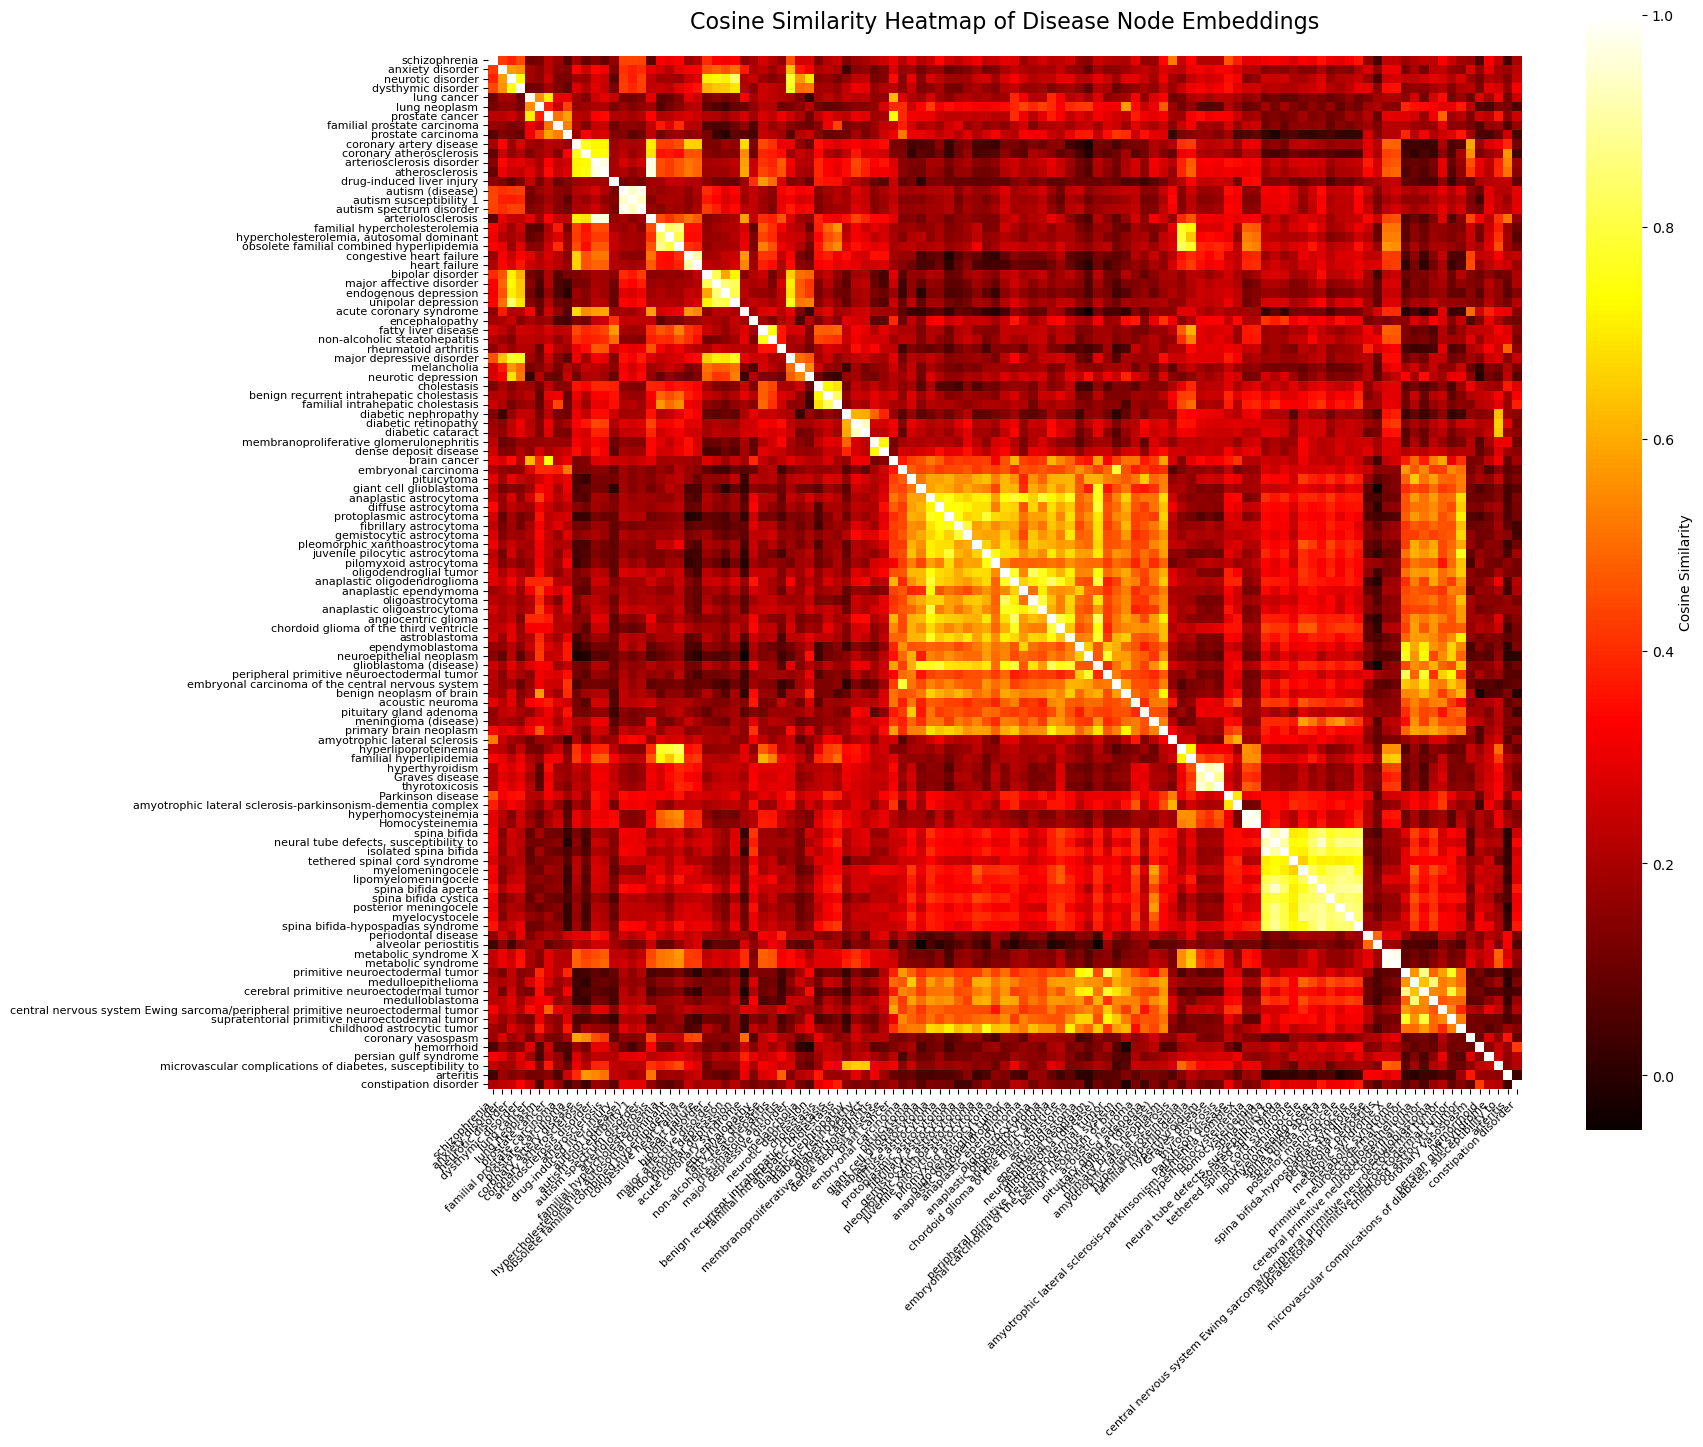

In [ ]:
disease_embeddings = []
disease_labels = []
subgraph_nodes = generate_subgraph(mpnet_embeddings)
for i, node in enumerate(subgraph_nodes):
    if node.metadata['node_type'] == 'disease':
        disease_embeddings.append(node.embedding)
        disease_labels.append(node.metadata['node_name'])

similarity = cosine_similarity(disease_embeddings, disease_embeddings)

# Create a DataFrame for better handling
import pandas as pd
similarity_df = pd.DataFrame(similarity, index=disease_labels, columns=disease_labels)

# Create a more readable heatmap using seaborn
plt.figure(figsize=(18, 15))
sns.heatmap(similarity_df, 
            annot=False,  # Set to True if you want values in cells
            cmap='hot', 
            square=True,
            cbar_kws={'label': 'Cosine Similarity'},
            xticklabels=True,
            yticklabels=True)

plt.title("Cosine Similarity Heatmap of Disease Node Embeddings", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Evaluate clusters

## semantic coherence 

In [13]:
def plot_disease_clusters(results, all_nodes_embedded, model_name=""):
    """
    Plot disease node embeddings colored by cluster assignments with centroids.
    """
    # Get disease labels in the same order
    subgraph_nodes = generate_subgraph(all_nodes_embedded)
    disease_labels = []
    for node in subgraph_nodes:
        if node.metadata['node_type'] == 'disease':
            disease_labels.append(node.metadata['node_name'])
    
    # Create a mapping from disease names to cluster labels
    label_to_cluster = {}
    for cluster_id, diseases in results['cluster_assignments'].items():
        for disease in diseases:
            label_to_cluster[disease] = cluster_id

    # Map labels to cluster IDs
    numeric_labels = [label_to_cluster[label] for label in disease_labels]

    # Plot the embeddings
    plt.figure(figsize=(15, 12))  # Larger figure size
    scatter = plt.scatter(results['reduced_embeddings'][:, 0], results['reduced_embeddings'][:, 1], 
                         c=numeric_labels, cmap='tab10', s=100, alpha=0.7, 
                         edgecolors='black', linewidth=1, label='Disease Nodes')

    # Plot centroids using the reduced space centroids (no transformation needed)
    # if results['cluster_centroids']: # plot centroids 
        # centroid_scatter = plt.scatter([c[0] for c in results['cluster_centroids']], 
        #                              [c[1] for c in results['cluster_centroids']],
        #                              c='red', marker='x', s=100, alpha=0.9,
        #                              linewidth=2, label='Cluster Centroids')
        
        # Add centroid labels
        # for i, centroid in enumerate(results['cluster_centroids']):
        #     plt.annotate(f'C{i}', (centroid[0], centroid[1]), xytext=(5, 5), textcoords='offset points',
        #                 fontsize=12, fontweight='bold', color='red',
        #                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Add disease labels
    texts = []
    for i, txt in enumerate(disease_labels):
        display_txt = txt if len(txt) <= 25 else txt[:22] + "..."
        texts.append(plt.text(results['reduced_embeddings'][i, 0], results['reduced_embeddings'][i, 1], display_txt, 
                              fontsize=9, ha='center', va='center'))
    
    adjust_text(texts, 
                arrowprops=dict(arrowstyle="->", color='gray', lw=0.5, alpha=0.7),
                expand_points=(2, 2),
                expand_text=(1.5, 1.5),
                force_points=0.5,
                force_text=0.5)
    # Add a legend, with one label for each cluster with the same color as the scatter plot
    unique_clusters = set(numeric_labels)   
    plt.legend(handles=scatter.legend_elements()[0], 
               labels=[f'Cluster {i+1}' for i in unique_clusters],
               loc='best', fontsize=13, title="Clusters", title_fontsize=15)
    # Add title and labels
    plt.title(f'Disease nodes with cluster labels - Model: {model_name}', fontsize=14, pad=20)
    plt.xlabel("UMAP Component 1", fontsize=12)
    plt.ylabel("UMAP Component 2", fontsize=12)
    plt.show()

In [ ]:
def analyze_cluster_semantics_original_space(all_nodes_embedded, random_state):
    """
    Perform clustering in original high-dimensional space, use UMAP only for visualization.
    """
    # Get disease data
    subgraph_nodes = generate_subgraph(all_nodes_embedded)
    disease_embeddings = []
    disease_labels = []
    
    for node in subgraph_nodes:
        if node.metadata['node_type'] == 'disease':
            disease_embeddings.append(node.embedding)
            disease_labels.append(node.metadata['node_name'])
       
    # Cluster in ORIGINAL high-dimensional space
    cluster_range = range(2, min(6, len(disease_embeddings)))
    silhouette_scores = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(disease_embeddings)  # Use original embeddings!
        silhouette_avg = silhouette_score(disease_embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    
    optimal_k = cluster_range[np.argmax(silhouette_scores)]
    
    # Final clustering in original space
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(disease_embeddings)
    
    # UMAP only for visualization
    reducer = umap.UMAP(n_components=2, random_state=random_state, n_jobs=1)
    reduced_embeddings = reducer.fit_transform(disease_embeddings)
    
    # Calculate similarities in original space
    similarity_matrix = cosine_similarity(disease_embeddings)
    
    # Intra-cluster similarities
    intra_cluster_similarities = []
    for i in range(len(disease_embeddings)):
        for j in range(i+1, len(disease_embeddings)):
            if cluster_labels[i] == cluster_labels[j]:
                similarity = similarity_matrix[i, j]
                intra_cluster_similarities.append(similarity)
    
    # Inter-cluster similarities (centroids in original space)
    cluster_centroids_original = []
    for cluster_id in range(optimal_k):
        cluster_embeddings = [disease_embeddings[i] for i, label in enumerate(cluster_labels) if label == cluster_id]
        if cluster_embeddings:
            centroid = np.mean(cluster_embeddings, axis=0)
            cluster_centroids_original.append(centroid)
    
   
    # Inter-cluster similarities
    inter_cluster_similarities = []
    if len(cluster_centroids_original) > 1:
        centroid_similarity_matrix = cosine_similarity(cluster_centroids_original)
        for i in range(len(cluster_centroids_original)):
            for j in range(i+1, len(cluster_centroids_original)):
                inter_cluster_similarities.append(centroid_similarity_matrix[i, j])
    
    avg_intra_sim = np.mean(intra_cluster_similarities) if intra_cluster_similarities else 0.0
    avg_inter_sim = np.mean(inter_cluster_similarities) if inter_cluster_similarities else 0.0
    separation_ratio = avg_intra_sim / avg_inter_sim if avg_inter_sim > 0 else float('inf')
       
    return {
        'optimal_k': optimal_k,
        'cluster_range': list(cluster_range),
        'silhouette_scores': silhouette_scores,
        'intra_cluster_sim': avg_intra_sim,
        'inter_cluster_sim': avg_inter_sim,
        'separation_ratio': separation_ratio,
        'cluster_assignments': {i: [disease_labels[j] for j, label in enumerate(cluster_labels) if label == i] 
                               for i in range(optimal_k)},
        'cluster_centroids_original': cluster_centroids_original,
        'reduced_embeddings': reduced_embeddings,
        'clustering_space': 'original',
        'cluster_labels': cluster_labels
    }

/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


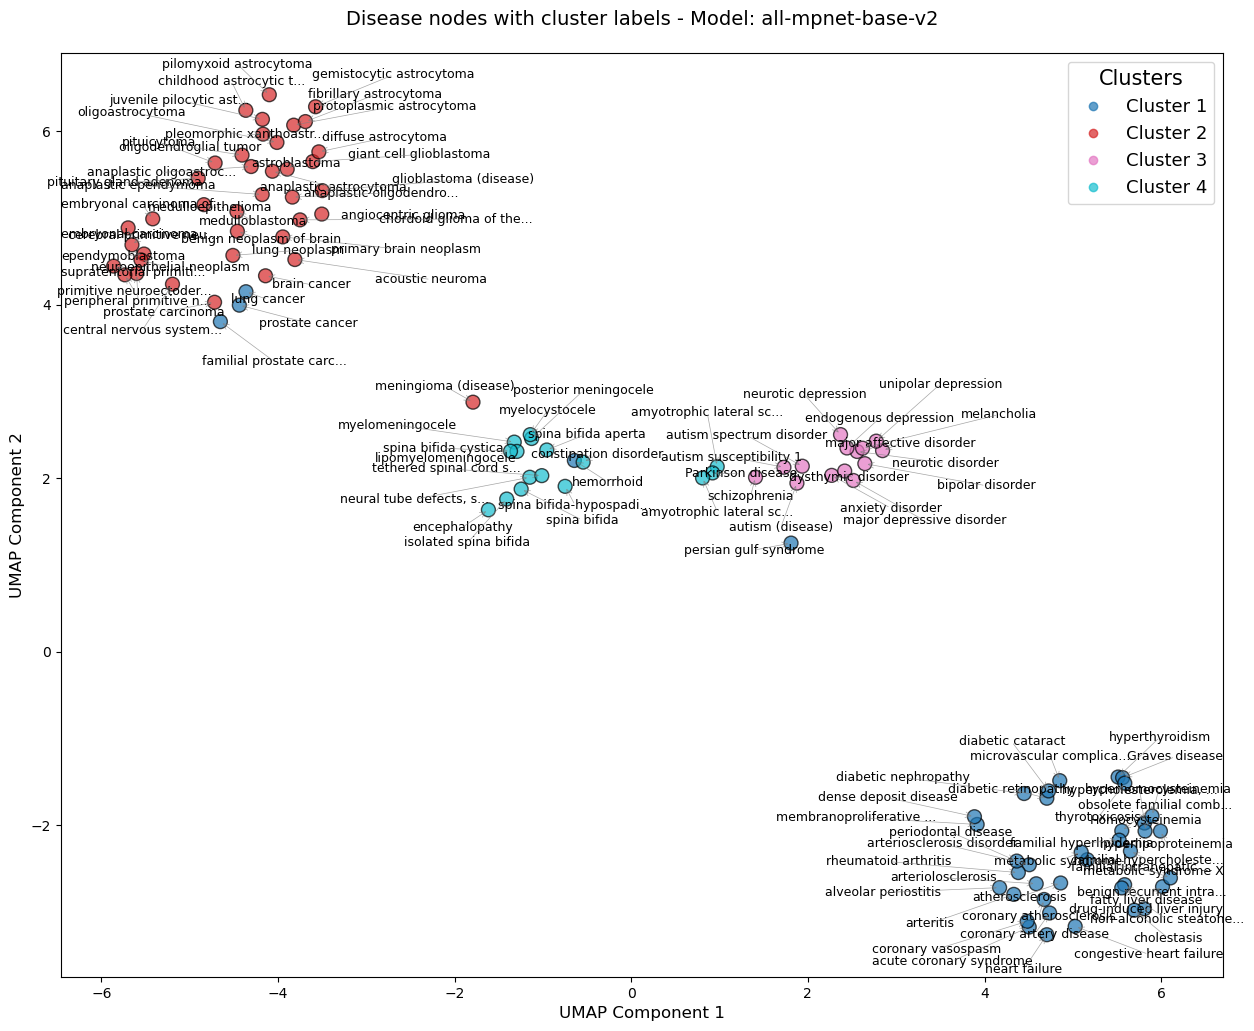

In [15]:
results_mpnet = analyze_cluster_semantics_original_space(all_nodes_embedded=mpnet_embeddings, random_state=40)
plot_disease_clusters(results=results_mpnet, all_nodes_embedded=mpnet_embeddings, model_name="all-mpnet-base-v2")

/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


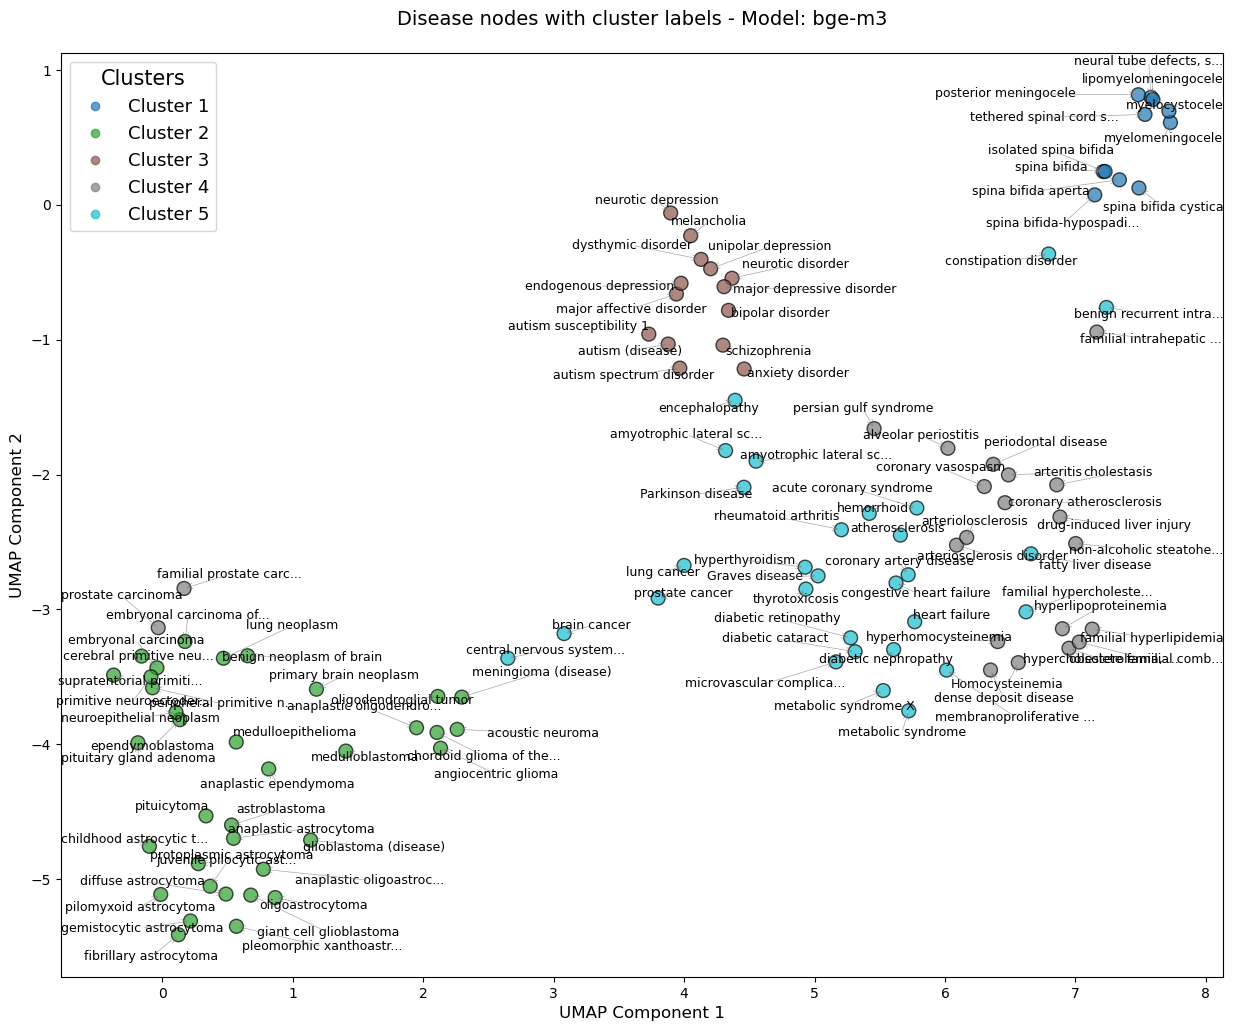

In [16]:
results_bge = analyze_cluster_semantics_original_space(all_nodes_embedded=bge_embeddings, random_state=56)
plot_disease_clusters(results=results_bge, all_nodes_embedded=bge_embeddings, model_name="bge-m3")

### result tables

In [17]:
# make a table with the results for bge and mpnet
def create_clustering_results_table(results_mpnet, results_bge):
    """
    Create a DataFrame summarizing clustering results for both models.
    """
    data = {
        'Model': ['all-mpnet-base-v2', 'bge-m3'],
        'Optimal k': [results_mpnet['optimal_k'], results_bge['optimal_k']],
        'Silhouette Scores': [np.max(results_mpnet['silhouette_scores']), np.max(results_bge['silhouette_scores'])],
        'Intra-cluster Sim': [results_mpnet['intra_cluster_sim'], results_bge['intra_cluster_sim']],
        'Inter-cluster Sim': [results_mpnet['inter_cluster_sim'], results_bge['inter_cluster_sim']],
        'Separation Ratio': [results_mpnet['separation_ratio'], results_bge['separation_ratio']]
    }
    
    df = pd.DataFrame(data)
    return df
results_table = create_clustering_results_table(results_mpnet, results_bge)
results_table


,Model,Optimal k,Silhouette Scores,Intra-cluster Sim,Inter-cluster Sim,Separation Ratio
0,all-mpnet-base-v2,4,0.148720,0.426528,0.429836,0.992305
1,bge-m3,5,0.113361,0.642950,0.779118,0.825228


In [9]:
# make a table with the diseases that are in the clusters for both models
def create_cluster_diseases_table(results_mpnet, results_bge):
    """
    Create a DataFrame summarizing diseases in clusters for both models.
    """
    data = {
        'Model': [],
        'Cluster number': [],
        'Number of Diseases': [],
        'Diseases': []

    }
    
    for model_name, results in zip(['all-mpnet-base-v2', 'bge-m3'], [results_mpnet, results_bge]):
        for cluster_id, diseases in results['cluster_assignments'].items():
            data['Model'].append(model_name)
            data['Cluster number'].append(cluster_id+1)
            data['Diseases'].append(', '.join([d.capitalize() for d in diseases]))
            data['Number of Diseases'].append(len(diseases))
    
    df = pd.DataFrame(data)
    return df
cluster_diseases_table = create_cluster_diseases_table(results_mpnet, results_bge)
cluster_diseases_table



,Model,Cluster number,Number of Diseases,Diseases
0,all-mpnet-base-v2,1,42,"Lung cancer, Prostate cancer, Familial prostat..."
1,all-mpnet-base-v2,2,39,"Lung neoplasm, Prostate carcinoma, Brain cance..."
2,all-mpnet-base-v2,3,14,"Schizophrenia, Anxiety disorder, Neurotic diso..."
3,all-mpnet-base-v2,4,16,"Encephalopathy, Amyotrophic lateral sclerosis,..."
4,bge-m3,1,11,"Spina bifida, Neural tube defects, susceptibil..."
5,bge-m3,2,36,"Lung neoplasm, Embryonal carcinoma, Pituicytom..."
6,bge-m3,3,14,"Schizophrenia, Anxiety disorder, Neurotic diso..."
7,bge-m3,4,21,"Familial prostate carcinoma, Prostate carcinom..."
8,bge-m3,5,29,"Lung cancer, Prostate cancer, Coronary artery ..."
